In [1]:
import IPython.display

IPython.display.display(
    IPython.display.HTML(
        data="""\
    <style>
        div#notebook-container    { width: 100%; }
        div#menubar-container     { width: 100%; }
        div#maintoolbar-container { width: 100%; }
    </style>
        """
    )
)

# Power analysis based on simulations

Simulate a large number of 2x2 contigency tables based on different proportions and estimate the power of Fisher's exact test.

In [2]:
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.stats import fisher_exact
import multiprocessing

In [3]:
def simulate_contingency_table(n1: int, n2: int, p1: float, p2: float) -> np.ndarray:
    group1 = np.random.binomial(n1, p1)
    group2 = np.random.binomial(n2, p2)
    table = np.array([[group1, n1 - group1], [group2, n2 - group2]])
    return table

In [4]:
def simulate_table_and_calc_pval(n1: int, n2: int, p1: float, p2: float) -> float:
    """Simulates a contigency table based on different proportions and calculates a p-value based on it."""
    table = simulate_contingency_table(n1, n2, p1, p2)
    _, p_value = fisher_exact(table)
    return p_value

In [5]:
def estimate_power(
    n1: int,
    n2: int,
    p1: float,
    p2: float,
    alpha: float,
    num_simulations: int,
) -> float:
    """Estimates the power of Fisher's exact test with simulation.
    
    Args:
        n1, n2, p1, p2: input to be used for simulation.
        alpha: target false positive rate.
        num_simulations: how many 2x2 tables to simulate.
    """
    with multiprocessing.Pool(processes=16) as pool:
        pvals = pool.starmap(
            simulate_table_and_calc_pval,
            [(n1, n2, p1, p2)] * num_simulations,
            chunksize=500,
        )
    pvals = np.array(list(pvals))
    power = len(pvals[pvals < alpha]) / len(pvals)
    return power

In [6]:
# Example of low power.
%time power = estimate_power(n1=100, n2=100, p1=0.3, p2=0.35, alpha=0.05, num_simulations=1000)
print(f'{power=:}')

CPU times: user 15.3 ms, sys: 53.3 ms, total: 68.6 ms
Wall time: 662 ms
power=0.112


In [7]:
# Example of high power, only p2 is changed from the low-power example.
%time power = estimate_power(n1=100, n2=100, p1=0.3, p2=0.5, alpha=0.05, num_simulations=1000)
print(f'{power=:}')

CPU times: user 2.77 ms, sys: 63.1 ms, total: 65.9 ms
Wall time: 744 ms
power=0.786


# Fix n, various p

In [8]:
%%time
out = []
for p1 in tqdm(np.arange(0.01, 1.01, 0.01)):
    for p2 in np.arange(0.01, 1.01, 0.01):
        out.append(
            {
                "p1": p1,
                "p2": p2,
                "power": estimate_power(
                    n1=100, n2=100, p1=p1, p2=p2, alpha=0.05, num_simulations=1000
                ),
            }
        )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:58:48<00:00, 71.29s/it]

CPU times: user 1min 47s, sys: 8min 33s, total: 10min 21s
Wall time: 1h 58min 48s


In [22]:
df_power = pd.DataFrame(out).assign(delta_p=lambda df: df.p1 - df.p2)

In [23]:
df_power.head()

,p1,p2,power,delta_p
0,0.01,0.01,0.000,0.00
1,0.01,0.02,0.002,-0.01
2,0.01,0.03,0.028,-0.02
3,0.01,0.04,0.084,-0.03
4,0.01,0.05,0.168,-0.04


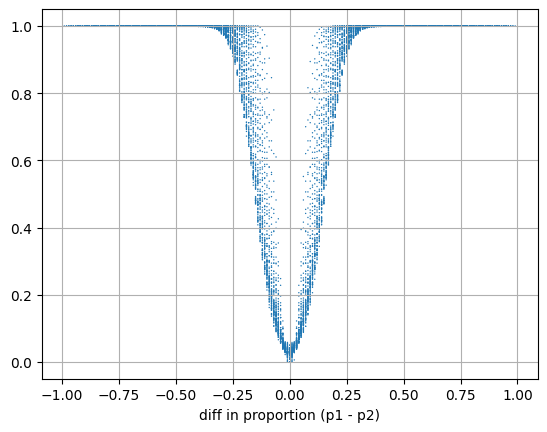

In [53]:
fig, ax = plt.subplots(1, 1)
ax.scatter(df_power.delta_p, df_power.power, s=1, edgecolor='none')
ax.set(xlabel='diff in proportion (p1 - p2)')
ax.grid()

As seen, when the difference in proportion is larger, the power also gets larger and plateaued at 1, and there is a steep increase in power around difference at 0.

In [25]:
df_pivot = df_power.pivot(index='p1', columns='p2', values='power')

x = df_pivot.columns.to_numpy()
y = df_pivot.index.to_numpy()

X, Y = np.meshgrid(x, y)

Z = df_pivot.to_numpy()

[Text(0.5, 0, 'p1'),
 Text(0, 0.5, 'p2'),
 Text(0.5, 1.0, 'power contour for n1=n2=100')]

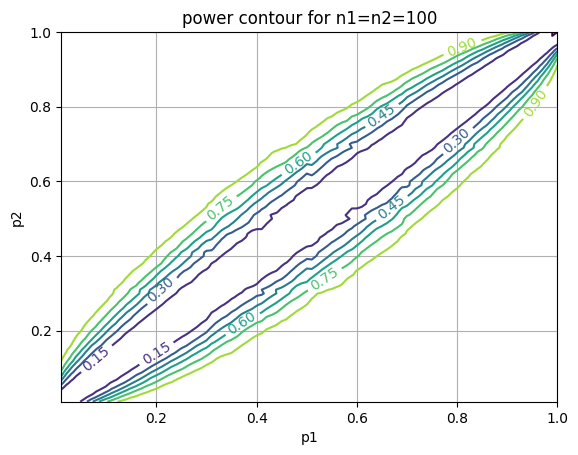

In [36]:
fig, ax = plt.subplots()

CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=True, fontsize=10)
ax.grid()
ax.set(xlabel='p1', ylabel='p2', title='power contour for n1=n2=100')

# Fix p, various n

In [38]:
%%time

out = []
for n1 in tqdm(np.arange(1, 110, 1).tolist()):
    for n2 in np.arange(1, 110, 1).tolist():
        # Calculate power
        power = estimate_power(
            n1=n1, n2=n2, p1=0.6, p2=0.8, alpha=0.05, num_simulations=1000
        )
        out.append({"n1": n1, "n2": n2, "power": power})

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [2:13:26<00:00, 73.46s/it]

CPU times: user 2min 17s, sys: 15min 53s, total: 18min 11s
Wall time: 2h 13min 26s


In [56]:
# 2 is just used to distinguish from previous df_power where n is fixed, but p varies.
df_power2 = pd.DataFrame(out).assign(delta_n=lambda df: df.n1 - df.n2, total_sample_size=lambda df: df.n1 + df.n2)

In [57]:
df_power2.head()

,n1,n2,power,delta_n,total_sample_size
0,1,1,0.0,0,2
1,1,2,0.0,-1,3
2,1,3,0.0,-2,4
3,1,4,0.0,-3,5
4,1,5,0.0,-4,6


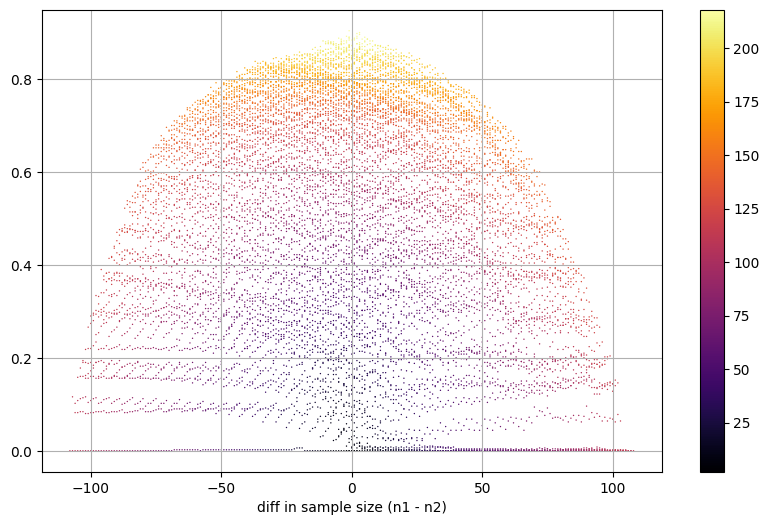

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
scatter = ax.scatter(
    df_power2.delta_n,
    df_power2.power,
    s=1,
    edgecolor="none",
    c=df_power2["total_sample_size"],
    cmap="inferno",
)
plt.colorbar(scatter)
ax.set(xlabel="diff in sample size (n1 - n2)")
ax.grid()

The asymmetry is probably due to `p1=0.6` is lower than `p2=0.8`, note when $\Delta_n = 0$, the power still ranges from 0 when n1 and n2 are both very low to about 0.85 when n1 and n2 are both relatively high, which is consistent with the contour plot shown earlier.

In [42]:
df_pivot2 = df_power2.pivot(index='n1', columns='n2', values='power')

In [44]:
x = df_pivot2.columns.to_numpy()
y = df_pivot2.index.to_numpy()

X, Y = np.meshgrid(x, y)

Z = df_pivot2.to_numpy()

[Text(0.5, 0, 'n1'),
 Text(0, 0.5, 'n2'),
 Text(0.5, 1.0, 'power contour for p1=0.6, p2=0.8')]

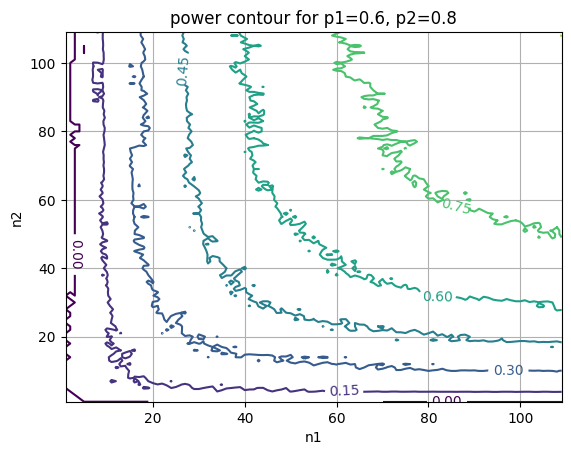

In [55]:
fig, ax = plt.subplots()

CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=True, fontsize=10)
ax.grid()
ax.set(xlabel='n1', ylabel='n2', title='power contour for p1=0.6, p2=0.8')